In [1]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import math

In [2]:
from astropy.table import Table
t = Table.read('../../ijoncour/StandCat/Tgas200_Wright2003_2MASS_FinCat.vot', format='votable')

In [3]:
print("The astropy reader loads the data into the following variable names:")
print(t.colnames)

The astropy reader loads the data into the following variable names:
['d_arcsec', 'd_arcsec_2', '_RAJ2000', '_DEJ2000', 'HIP', 'TYC2', 'Source', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var', '_RAJ2000_2', '_DEJ2000_2', 'TYC1', 'TYC2_2', 'TYC3', 'RAJ2000', 'DEJ2000', 'VTmag', 'BTmag', 'r_SpType', 'Dist', 'Teff', 'SpType', '_2MASS', 'RAJ2000_2', 'DEJ2000_2', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD']


In [4]:
#Rename columns
Source = t["Source"]
Gmag = t["__Gmag_"]
Vmag = t["VTmag"]
Bmag = t["BTmag"]
Jmag = t["Jmag"]
Hmag = t["Hmag"]
Kmag = t["Kmag"]
QFlags = t["Qfl"]
DistW = t["Dist"]
s1= t["d_arcsec"]
s2 = t["d_arcsec_2"]
plx = t['Plx']
Teff = t['Teff']
e_Jmag = t['e_Jmag']
e_Kmag = t['e_Kmag']
e_Hmag = t['e_Hmag']
SpType = t["SpType"]
dup = t['Dup']
RA = t["RAJ2000"]
DEC = t["_DEJ2000"]

In [5]:
#calculate distance and absolute magnitudes and plot color index vs. absolute g magnitude for different luminosity classes
Dist = 1000./t["Plx"]
Vmags = t['VTmag'] - 5 * np.log10(Dist) + 5
Bmags = t['BTmag'] - 5 * np.log10(Dist) + 5
Gmags = t['__Gmag_'] - 5 * np.log10(Dist) + 5
Jmags = t['Jmag'] -5 * np.log10(Dist) + 5
Hmags = t['Hmag'] - 5 * np.log10(Dist) + 5
Kmags = t['Kmag'] - 5 * np.log10(Dist) + 5

In [6]:
#mask all values with dup = 1
imask = 0
for i in range(0,len(dup)):
    if (dup[i] > 0.5):
        imask = imask + 1
        row = t[i]
        idx = row._index
        cols = row._table.columns.values()
        for col in cols:
            col.mask[i] = True
for i in range(0,len(dup)):
    if(dup[i] > 0.5):
        print(i,dup[i])
print(" Masked ",imask," rows in which dup is equal to 1")

 Masked  25429  rows in which dup is equal to 1


In [7]:
#look at number of duplicate matches
Test = Source.compressed()
unique = set()
Gdups = set()

for i in range(0,len(Test)):
    if(Test[i] in unique):
        print("GAIA Duplicate Source: ",Test[i])
        Gdups.add(Test[i])
    else:
        unique.add(Test[i])
        last = Test[i]
print("Finished GAIA Duplicate Check. Found: ", len(Gdups))

for i in range(0,len(Source)):
    if(Source.mask[i] == False):
        Name = Source[i]
        if(Name in Gdups):
            row = t[i]
            idx = row._index
            cols = row._table.columns.values()
            for col in cols:
                col.mask[i] = True
print("Finished masking all GAIA duplicates. All sources involved")

TwoM = t["_2MASS"]
unique = set()
Tdups = set()
Test = TwoM.compressed()
for i in range(0,len(Test)):
    if(Test[i] in unique):
        print("2MASS Duplicate Source: ",Test[i])
        Tdups.add(Test[i])
    else:
        unique.add(Test[i])
        last = Test[i]
print("Finished 2MASS Duplicate Check. Found: ", len(Tdups))

for i in range(0,len(Source)):
    if(Source.mask[i] == False):
        Name = Source[i]
        if(Name in Tdups):
            print(Source[i],s1[i],s2[i],Gmag[i],Vmag[i]-Gmag[i],Jmag[i],Kmag[i],TwoM[i])

GAIA Duplicate Source:  6726788842835559552
GAIA Duplicate Source:  5140648418166947328
GAIA Duplicate Source:  2520020864918288896
GAIA Duplicate Source:  5959478126358758016
GAIA Duplicate Source:  6668487925962916480
GAIA Duplicate Source:  1214512606941823360
GAIA Duplicate Source:  4097002323363211776
GAIA Duplicate Source:  5769091159655753856
GAIA Duplicate Source:  6790250970359184768
GAIA Duplicate Source:  5123327399177495808
GAIA Duplicate Source:  6785793275342096256
GAIA Duplicate Source:  2498832038900176000
GAIA Duplicate Source:  5324415053561705216
GAIA Duplicate Source:  2067478096721765376
GAIA Duplicate Source:  4785096491234658304
GAIA Duplicate Source:  5447076227156166528
GAIA Duplicate Source:  6054493694983536384
GAIA Duplicate Source:  5133580860502607104
GAIA Duplicate Source:  452193638896601088
GAIA Duplicate Source:  1837550183626334848
GAIA Duplicate Source:  3248442439236776960
GAIA Duplicate Source:  4392970203357519360
GAIA Duplicate Source:  567531810

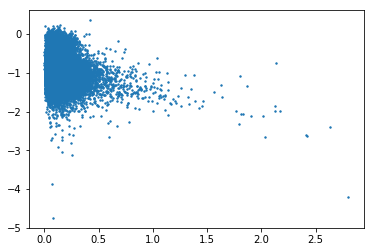

-0.878488668698
0.295729219034


In [8]:
J_G = Jmag-Gmag
plt.scatter(s1,J_G,s=2.0)
plt.show()
JGmean = np.mean(J_G)
JGstd = np.std(J_G)
print(JGmean)
print(JGstd)

 Masked  27  rows based on J-G color > 5 sigma from mean


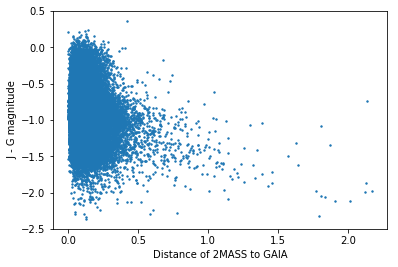

New sigma for J-G:  0.29215581638


In [9]:
#masked rows with J-G greater than 5 sigma from mean
imask = 0
for i in range(0,len(J_G)):
    if(abs(J_G[i] - JGmean) > 5*JGstd):
        imask = imask + 1
        row = t[i]
        idx = row._index
        cols = row._table.columns.values()
        for col in cols:
            col.mask[i] = True
print(" Masked ",imask," rows based on J-G color > 5 sigma from mean")
J_G = Jmag - Gmag
plt.xlabel("Distance of 2MASS to GAIA")
plt.ylabel(" J - G magnitude")
plt.scatter(s1,J_G,s=2.0)
plt.show()
print("New sigma for J-G: ",np.std(J_G))

In [10]:
#Translate Spectra Type luminosity class into a number from 1 to 5
#or a negative number if it is a binary or unknown spectral type.
#Note that many stars do not have a luminosity class. There are given 5.1.

SpTypeN = [0.0]*len(SpType)
for i in range(0,len(SpType)):
    if(SpType.mask[i] == False):
        SpT = SpType[i].decode()
        if(len(SpT) > 2):
            for j in range(0,len(SpT)):
                if(SpT[j] == 'I'):
                    SpTypeN[i] = SpTypeN[i] + 1
                if(SpT[j] == 'V'):
                    SpTypeN[i] = SpTypeN[i] + 5
                if(SpT[j] == '+'):
                    SpTypeN[i] = -20.
                
        else:
            SpTypeN[i] = 5.1
        
        if(SpTypeN[i] == 6):
            SpTypeN[i] = 4.
        if(SpTypeN[i] == 11):
            SpTypeN[i] = 4.5
        if(SpTypeN[i] == 9):
            SpTypeN[i] = 3.5
        if(SpTypeN[i] > 5.2):
            SpTypeN[i] = -30.
print("Finished Luminosity Class Translation")
count = 0
for i in range(0,len(SpType)):
    if(SpTypeN[i] < 0.):
        count = count + 1
test = SpType.compressed()
good = len(test) - count
print("  Number of single Stars: ",good,"  Binaries or Unknown luminosity class: ",count)

Finished Luminosity Class Translation
  Number of single Stars:  49713   Binaries or Unknown luminosity class:  428


In [11]:
#Split class V stars into different temperature ranges and find avg, min, max, and standard deviation of each range
temps = [3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10500]
num_stars = np.zeros(len(temps))
temp_cat = np.zeros(len(Teff))
tavg = []
tmin = []
tmax = []
t_stdev = []
j = 0
for t1 in temps: 
    stars = 0
    t2 = t1 + 500
    temp_array = []
    for i in range(len(Teff)):
        if (SpTypeN[i] > 4.9 and SpTypeN[i] < 5.05):
            if (Teff[i] >= t1 and Teff[i] < t2):
                temp_cat[i] = t1
                temp_array = np.append(temp_array, Teff[i])
                stars = stars+1
    tavg = np.append(tavg,np.mean(temp_array))
    tmax = np.append(tmax,np.max(temp_array,axis =0))
    tmin = np.append(tmin,np.min(temp_array,axis =0))
    t_stdev = np.append(t_stdev,np.std(temp_array))
    print(str(t1) + 'K : ' + str(stars))
    num_stars[j] = stars
    j = j+1
print(tavg)
print(tmax)
print(tmin)
print(t_stdev)
print(num_stars)

3500K : 10
4000K : 88
4500K : 296
5000K : 452
5500K : 4528
6000K : 8407
6500K : 3061
7000K : 897
7500K : 628
8000K : 194
8500K : 544
9000K : 274
9500K : 346
10500K : 179
[  3797.           4267.27272727   4780.87837838   5191.28318584
   5788.28180212   6316.05685738   6889.92812806   7201.1148272
   7847.77070064   8194.32989691   8817.13235294   9224.19708029   9520.
  10500.        ]
[  3850.   4420.   4900.   5450.   5860.   6470.   6890.   7450.   7850.
   8200.   8970.   9480.   9520.  10500.]
[  3580.   4000.   4590.   5080.   5570.   6030.   6870.   7150.   7650.
   8100.   8600.   9000.   9520.  10500.]
[  88.66228059  143.63564442  114.12078152   81.80020653   96.32472367
  174.87706937    1.19677616   19.00199992   20.9973831    23.12704564
  127.74001681   41.7007657     0.            0.        ]
[   10.    88.   296.   452.  4528.  8407.  3061.   897.   628.   194.
   544.   274.   346.   179.]


In [12]:
#Split Class V stars into different distance ranges, assign each star a distance category
distances = [100,150,200]
distance_cat = np.zeros(len(Dist))
stars = 0
for i in range(len(distances)): 
    if (i==0):
        d1 = 0
        d2 = distances[0]
    else:
        d1 = distances[i-1]
        d2 = d1+50
    for j in range(len(Dist)):
        if (SpTypeN[j] > 4.9 and SpTypeN[j] < 5.05):
            if (Dist[j] > d1 and Dist[j] <= d2):
                distance_cat[j] = d2
                stars = stars+1
print(stars)

19975


In [13]:
#Relative SED for all stars
temps2 = [4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10500]
wvl = [441, 551, 673, 1235, 1662, 2159]
wvl2 = [441, 551, 1235, 1662, 2159]
avg_temps = np.array([])
err_temps = np.array([])
stars = np.array([])
for t in temps2: 
    G_V_array = ma.array([])
    G_B_array = ma.array([])
    G_J_array = ma.array([])
    G_H_array = ma.array([])
    G_K_array = ma.array([])
    B = ma.array([])
    V = ma.array([])
    G = ma.array([])
    J = ma.array([])
    H = ma.array([])
    K = ma.array([])
    temperatures = np.array([])
    stars = 0
    for i in range(len(temp_cat)):
        if (temp_cat[i] == t and distance_cat[i] == 100):
            G_V_array = np.append(G_V_array,Gmags[i]-Vmags[i])
            G_B_array = np.append(G_B_array,Gmags[i]-Bmags[i])
            G_J_array = np.append(G_J_array,Gmags[i]-Jmags[i])
            G_H_array = np.append(G_H_array,Gmags[i]-Hmags[i])
            G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
            B = np.append(B,Bmags[i])
            V = np.append(V,Vmags[i])
            G = np.append(G,Gmags[i])
            J = np.append(J,Jmags[i])
            H = np.append(H,Hmags[i])
            K = np.append(K,Kmags[i])
            temperatures = np.append(temperatures,Teff[i])
            stars = stars +1
    #average temperatures
    avg_temps = np.append(avg_temps,np.mean(temperatures))
    err_temps = np.append(err_temps,np.std(temperatures))
    #number of stars per temperature
    stars = np.append(stars,stars)
    #relative SED
    mag_array = [np.mean(G_B_array), np.mean(G_V_array), np.mean(G_J_array), np.mean(G_H_array), np.mean(G_K_array)]
    std_array = [np.std(G_B_array), np.std(G_V_array), np.std(G_J_array), np.std(G_H_array), np.std(G_K_array)]
    #absolute SED
    mag_array2 = [np.mean(B), np.mean(V), np.mean(G), np.mean(J), np.mean(H), np.mean(K)]
    std_array2 = [np.std(B), np.std(V), np.std(G), np.std(J), np.std(H), np.std(K)]
    #add standard deviation error
    #val = np.sqrt(len(G_B_array))
    #std_array = std_array/val
    #val2 = np.sqrt(len(B))
    #std_array2 = std_array2/val2
    #stack SEDs
    if (t == temps2[0]):
        temp_mags = np.array(mag_array)
        temp_std = np.array(std_array)
        abs_temp_mags = np.array(mag_array2)
        abs_temp_std = np.array(std_array2)
    else:
        temp_mags = np.vstack((temp_mags,mag_array))
        temp_std = np.vstack((temp_std,std_array))
        abs_temp_mags = np.vstack((abs_temp_mags, mag_array2))
        abs_temp_std = np.vstack((abs_temp_mags, std_array2))

In [14]:
#Relative Magnitude SED for stars located within 100 pc of earth
avg_temps100 = np.array([])
err_temps100 = np.array([])
stars100 = np.array([])
for t in temps2: 
    G_V_array = ma.array([])
    G_B_array = ma.array([])
    G_J_array = ma.array([])
    G_H_array = ma.array([])
    G_K_array = ma.array([])
    B = ma.array([])
    V = ma.array([])
    G = ma.array([])
    J = ma.array([])
    H = ma.array([])
    K = ma.array([])
    temperatures = np.array([])
    stars = 0
    for i in range(len(temp_cat)):
        if (temp_cat[i] == t and distance_cat[i] == 100):
            G_V_array = np.append(G_V_array,Gmags[i]-Vmags[i])
            G_B_array = np.append(G_B_array,Gmags[i]-Bmags[i])
            G_J_array = np.append(G_J_array,Gmags[i]-Jmags[i])
            G_H_array = np.append(G_H_array,Gmags[i]-Hmags[i])
            G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
            B = np.append(B,Bmags[i])
            V = np.append(V,Vmags[i])
            G = np.append(G,Gmags[i])
            J = np.append(J,Jmags[i])
            H = np.append(H,Hmags[i])
            K = np.append(K,Kmags[i])
            temperatures = np.append(temperatures,Teff[i])
            stars = stars +1
    #average temperatures
    avg_temps100 = np.append(avg_temps100,np.mean(temperatures))
    err_temps100 = np.append(err_temps100,np.std(temperatures))
    #number of stars per temperature
    stars100 = np.append(stars100,stars)
    #relative SED
    mag_array = [np.mean(G_B_array), np.mean(G_V_array), np.mean(G_J_array), np.mean(G_H_array), np.mean(G_K_array)]
    std_array = [np.std(G_B_array), np.std(G_V_array), np.std(G_J_array), np.std(G_H_array), np.std(G_K_array)]
    #absolute SED
    mag_array2 = [np.mean(B), np.mean(V), np.mean(G), np.mean(J), np.mean(H), np.mean(K)]
    std_array2 = [np.std(B), np.std(V), np.std(G), np.std(J), np.std(H), np.std(K)]
    #add standard deviation error
    val = np.sqrt(len(G_B_array))
    std_array = std_array/val
    val2 = np.sqrt(len(B))
    std_array2 = std_array2/val2
    #stack SEDs
    if (t == temps2[0]):
        temp_mags100 = np.array(mag_array)
        temp_std100 = np.array(std_array)
        abs_temp_mags100 = np.array(mag_array2)
        abs_temp_std100 = np.array(std_array2)
    else:
        temp_mags100 = np.vstack((temp_mags100,mag_array))
        temp_std100 = np.vstack((temp_std100,std_array))
        abs_temp_mags100 = np.vstack((abs_temp_mags100, mag_array2))
        abs_temp_std100 = np.vstack((abs_temp_mags100, std_array2))

In [15]:
#Relative Magnitude SED for stars located between 100 and 150 parsecs
avg_temps150 = np.array([])
err_temps150 = np.array([])
stars150 = np.array([])
for t in temps2: 
    G_V_array = ma.array([])
    G_B_array = ma.array([])
    G_J_array = ma.array([])
    G_H_array = ma.array([])
    G_K_array = ma.array([])
    B = ma.array([])
    V = ma.array([])
    G = ma.array([])
    J = ma.array([])
    H = ma.array([])
    K = ma.array([])
    temperatures = np.array([])
    stars = 0
    for i in range(len(temp_cat)):
        if (temp_cat[i] == t and distance_cat[i] == 150):
            G_V_array = np.append(G_V_array,Gmags[i]-Vmags[i])
            G_B_array = np.append(G_B_array,Gmags[i]-Bmags[i])
            G_J_array = np.append(G_J_array,Gmags[i]-Jmags[i])
            G_H_array = np.append(G_H_array,Gmags[i]-Hmags[i])
            G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
            B = np.append(B,Bmags[i])
            V = np.append(V,Vmags[i])
            G = np.append(G,Gmags[i])
            J = np.append(J,Jmags[i])
            H = np.append(H,Hmags[i])
            K = np.append(K,Kmags[i])
            temperatures = np.append(temperatures,Teff[i])
            stars = stars +1
    #average temperatures
    avg_temps150 = np.append(avg_temps150,np.mean(temperatures))
    err_temps150 = np.append(err_temps150,np.std(temperatures))
    #number of stars per temperature
    stars150 = np.append(stars150,stars)
    #relative SED
    mag_array = [np.mean(G_B_array), np.mean(G_V_array), np.mean(G_J_array), np.mean(G_H_array), np.mean(G_K_array)]
    std_array = [np.std(G_B_array), np.std(G_V_array), np.std(G_J_array), np.std(G_H_array), np.std(G_K_array)]
    #absolute SED
    mag_array2 = [np.mean(B), np.mean(V), np.mean(G), np.mean(J), np.mean(H), np.mean(K)]
    std_array2 = [np.std(B), np.std(V), np.std(G), np.std(J), np.std(H), np.std(K)]
    #add standard deviation error
    val = np.sqrt(len(G_B_array))
    std_array = std_array/val
    val2 = np.sqrt(len(B))
    std_array2 = std_array2/val2
    #stack SEDs
    if (t == temps2[0]):
        temp_mags150 = np.array(mag_array)
        temp_std150 = np.array(std_array)
        abs_temp_mags150 = np.array(mag_array2)
        abs_temp_std150 = np.array(std_array2)
    else:
        temp_mags150 = np.vstack((temp_mags150,mag_array))
        temp_std150 = np.vstack((temp_std150,std_array))
        abs_temp_mags150 = np.vstack((abs_temp_mags150, mag_array2))
        abs_temp_std150 = np.vstack((abs_temp_mags150, std_array2))

In [16]:
#Relative Magnitude SED for stars located within 150 and 200 pc
avg_temps200 = np.array([])
err_temps200 = np.array([])
stars200 = np.array([])
for t in temps2: 
    G_V_array = ma.array([])
    G_B_array = ma.array([])
    G_J_array = ma.array([])
    G_H_array = ma.array([])
    G_K_array = ma.array([])
    B = ma.array([])
    V = ma.array([])
    G = ma.array([])
    J = ma.array([])
    H = ma.array([])
    K = ma.array([])
    temperatures = np.array([])
    stars = 0
    for i in range(len(temp_cat)):
        if (temp_cat[i] == t and distance_cat[i] == 200):
            G_V_array = np.append(G_V_array,Gmags[i]-Vmags[i])
            G_B_array = np.append(G_B_array,Gmags[i]-Bmags[i])
            G_J_array = np.append(G_J_array,Gmags[i]-Jmags[i])
            G_H_array = np.append(G_H_array,Gmags[i]-Hmags[i])
            G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
            B = np.append(B,Bmags[i])
            V = np.append(V,Vmags[i])
            G = np.append(G,Gmags[i])
            J = np.append(J,Jmags[i])
            H = np.append(H,Hmags[i])
            K = np.append(K,Kmags[i])
            temperatures = np.append(temperatures,Teff[i])
            stars = stars +1
    #average temperatures
    avg_temps200 = np.append(avg_temps200,np.mean(temperatures))
    err_temps200 = np.append(err_temps200,np.std(temperatures))
    #number of stars per temperature
    stars200 = np.append(stars200,stars)
    #relative SED
    mag_array = [np.mean(G_B_array), np.mean(G_V_array), np.mean(G_J_array), np.mean(G_H_array), np.mean(G_K_array)]
    std_array = [np.std(G_B_array), np.std(G_V_array), np.std(G_J_array), np.std(G_H_array), np.std(G_K_array)]
    #absolute SED
    mag_array2 = [np.mean(B), np.mean(V), np.mean(G), np.mean(J), np.mean(H), np.mean(K)]
    std_array2 = [np.std(B), np.std(V), np.std(G), np.std(J), np.std(H), np.std(K)]
    #add standard deviation error
    val = np.sqrt(len(G_B_array))
    std_array = std_array/val
    val2 = np.sqrt(len(B))
    std_array2 = std_array2/val2
    #stack SEDs
    if (t == temps2[0]):
        temp_mags200 = np.array(mag_array)
        temp_std200 = np.array(std_array)
        abs_temp_mags200 = np.array(mag_array2)
        abs_temp_std200 = np.array(std_array2)
    else:
        temp_mags200 = np.vstack((temp_mags200,mag_array))
        temp_std200 = np.vstack((temp_std200,std_array))
        abs_temp_mags200 = np.vstack((abs_temp_mags200, mag_array2))
        abs_temp_std200 = np.vstack((abs_temp_mags200, std_array2))

In [17]:
#Compare Average Temperatures
print(stars100)
print(avg_temps100)
print(stars150)
print(avg_temps150)
print(stars200)
print(avg_temps200)

[   71.   253.   395.  2495.  2552.   477.    93.    55.    29.    89.
    28.    25.     7.]
[  4244.78873239   4790.86956522   5187.08860759   5775.01803607
   6285.27037618   6889.95807128   7204.83870968   7839.09090909
   8193.10344828   8809.88764045   9221.78571429   9520.          10500.        ]
[    9.    16.    43.  1393.  3379.  1163.   308.   197.    70.   201.
   113.   131.    63.]
[  4365.55555556   4721.875        5219.30232558   5808.14788227
   6319.21278485   6889.94840929   7200.64935065   7850.           8192.85714286
   8826.51741294   9221.85840708   9520.          10500.        ]
[    8.    27.    14.   640.  2476.  1421.   496.   376.    95.   254.
   133.   190.   109.]
[  4356.25         4722.22222222   5223.57142857   5796.75         6343.48142165
   6889.90147783   7200.70564516   7847.87234043   8195.78947368
   8812.24409449   9226.69172932   9520.          10500.        ]


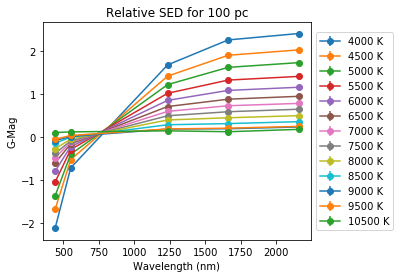

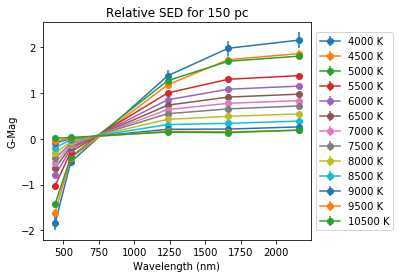

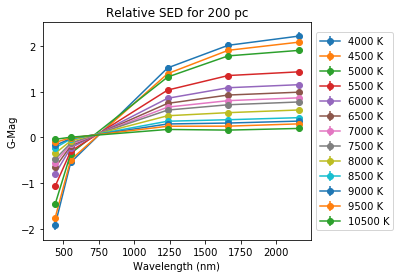

In [18]:
#Plot relative SED by distance 
plt.figure()
ax = plt.subplot(111)
for i in range(len(temps2)): 
    ax.errorbar(wvl2,temp_mags100[i,:],yerr = temp_std100[i,:],linestyle = '-', marker = 'o',label = str(temps2[i]) + ' K')
ax.set_title('Relative SED for 100 pc')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('G-Mag')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
ax = plt.subplot(111)
for i in range(len(temps2)): 
    ax.errorbar(wvl2,temp_mags150[i,:],yerr = temp_std150[i,:],linestyle = '-', marker = 'o',label = str(temps2[i]) + ' K')
ax.set_title('Relative SED for 150 pc')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('G-Mag')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
ax = plt.subplot(111)
for i in range(len(temps2)): 
    ax.errorbar(wvl2,temp_mags200[i,:],yerr = temp_std200[i,:],linestyle = '-', marker = 'o',label = str(temps2[i]) + ' K')
ax.set_title('Relative SED for 200 pc')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('G-Mag')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

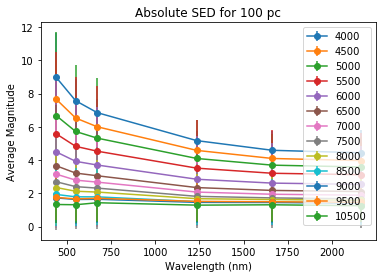

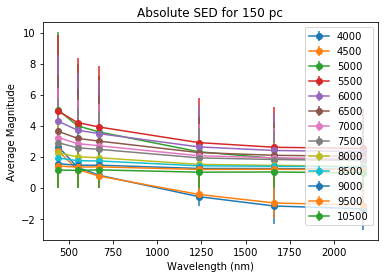

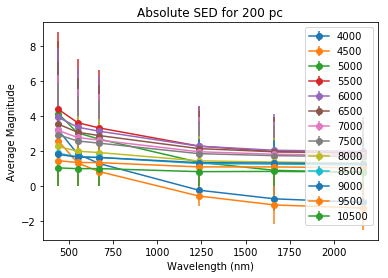

In [19]:
#Plot absolute SED for each distance
from matplotlib.backends.backend_pdf import PdfPages

plt.figure()
for i in range(len(temps2)): 
    plt.errorbar(wvl,abs_temp_mags100[i,:],yerr = abs_temp_std150[i,:],linestyle = '-', marker = 'o',label = str(temps2[i]))
    plt.title('Absolute SED for 100 pc')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Average Magnitude')
    plt.legend()
    
plt.figure()
for i in range(len(temps2)): 
    plt.errorbar(wvl,abs_temp_mags150[i,:],yerr = abs_temp_std150[i,:],linestyle = '-', marker = 'o',label = str(temps2[i]))
    plt.title('Absolute SED for 150 pc')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Average Magnitude')
    plt.legend()

pdf1 = PdfPages('AbsoluteSED_200pc.pdf')
plt.figure()
for i in range(len(temps2)): 
    plt.errorbar(wvl,abs_temp_mags200[i,:],yerr = abs_temp_std200[i,:],linestyle = '-', marker = 'o',label = str(temps2[i]))
    plt.title('Absolute SED for 200 pc')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Average Magnitude')
    plt.legend()
pdf1.savefig()
pdf1.close()

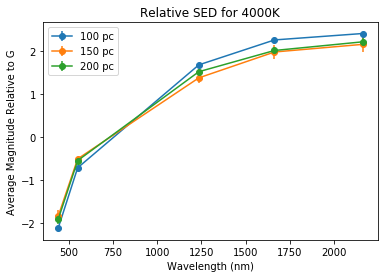

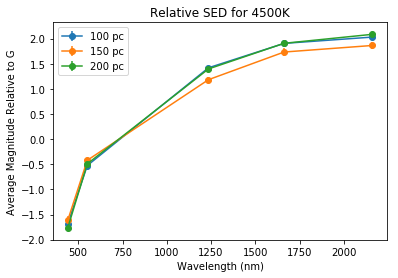

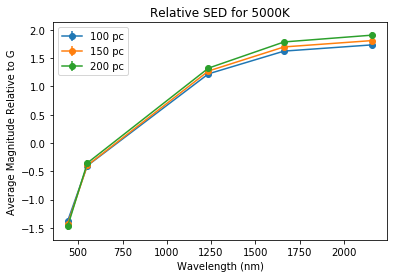

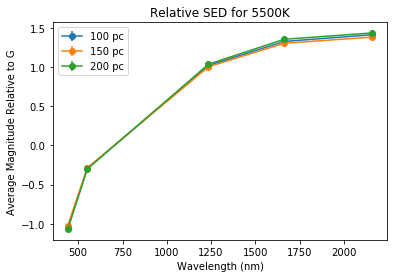

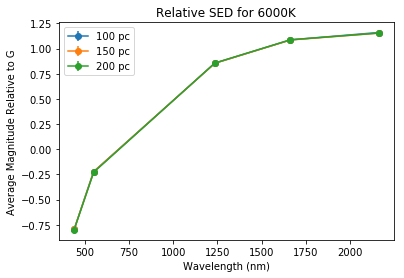

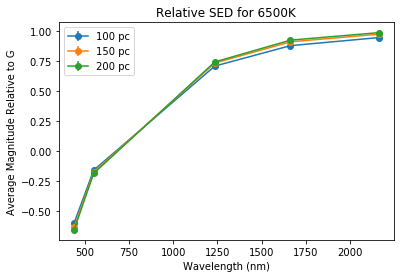

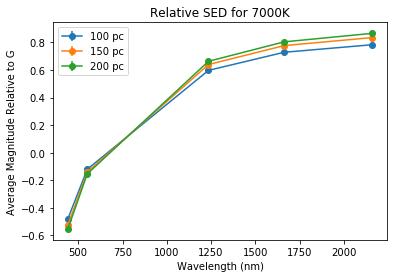

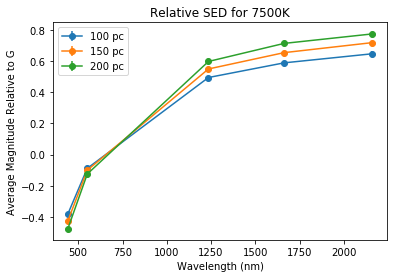

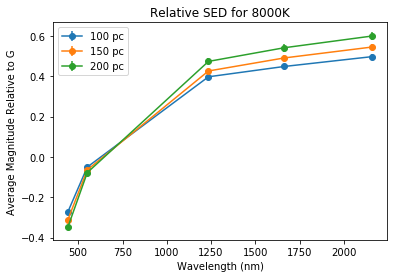

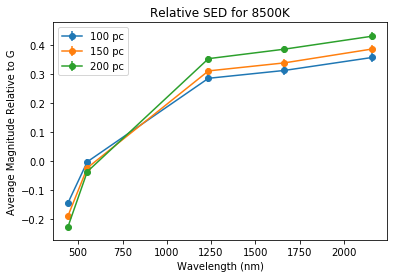

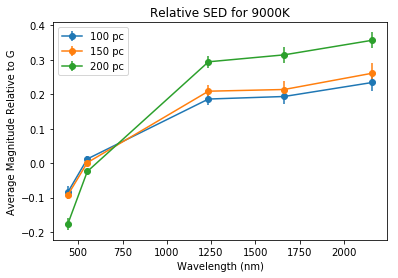

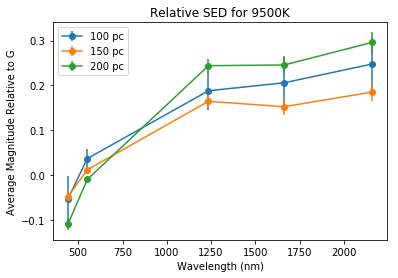

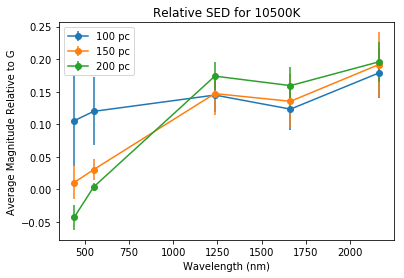

In [20]:
#Compare Templates: For each temperature category (4000 to 10500) plot Relative SED
for i in range(len(temps2)): 
    plt.figure()
    plt.errorbar(wvl2,temp_mags100[i],yerr = temp_std100[i],linestyle = '-', marker = 'o',label = '100 pc')
    plt.errorbar(wvl2,temp_mags150[i],yerr = temp_std150[i],linestyle = '-', marker = 'o', label = '150 pc')
    plt.errorbar(wvl2,temp_mags200[i],yerr = temp_std200[i],linestyle = '-', marker = 'o', label = '200 pc')
    plt.title('Relative SED for '+ str(temps2[i]) + 'K')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Average Magnitude Relative to G')
    plt.legend()



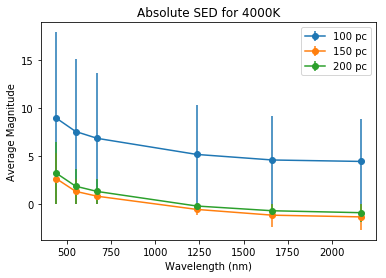

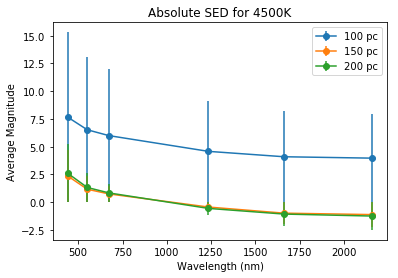

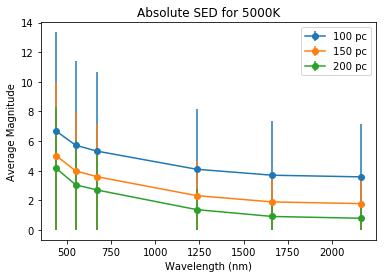

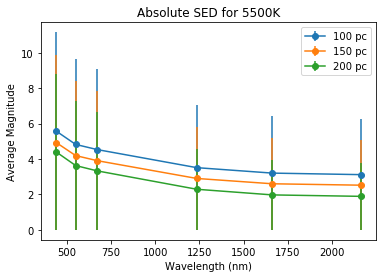

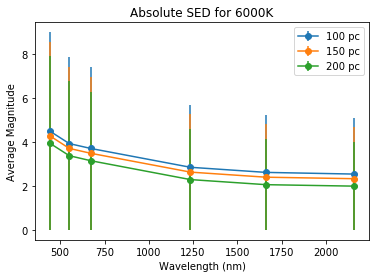

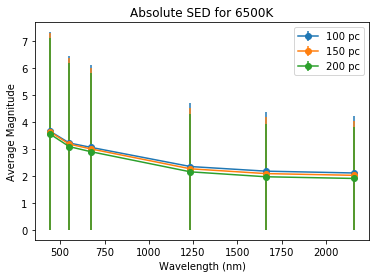

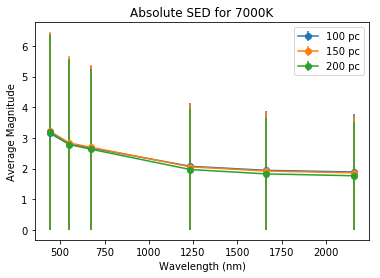

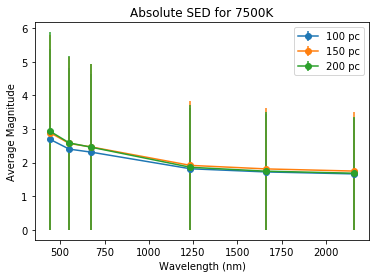

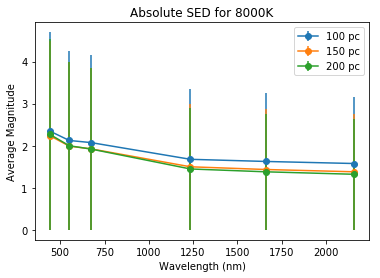

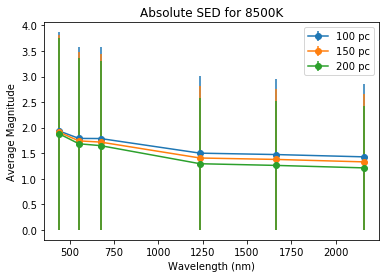

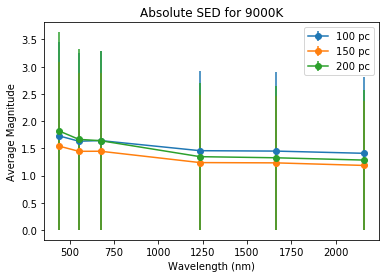

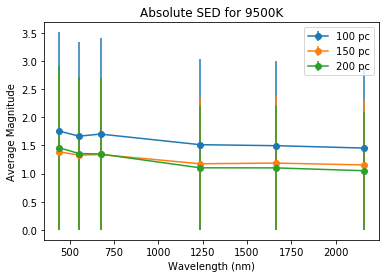

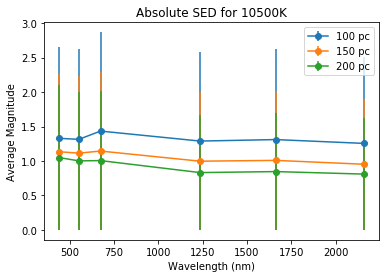

In [21]:
#Compare_templates: For each temperature category (starting at 4000) plot absolute SED
pdf2 = PdfPages('AbsoluteSED_5000K')
for i in range(len(temps2)): 
    plt.figure()
    plt.errorbar(wvl,abs_temp_mags100[i],yerr = abs_temp_std100[i],linestyle = '-', marker = 'o',label = '100 pc')
    plt.errorbar(wvl,abs_temp_mags150[i],yerr = abs_temp_std150[i],linestyle = '-', marker = 'o', label = '150 pc')
    plt.errorbar(wvl,abs_temp_mags200[i],yerr = abs_temp_std200[i],linestyle = '-', marker = 'o', label = '200 pc')
    plt.title('Absolute SED for '+ str(temps2[i]) + 'K')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Average Magnitude')
    plt.legend()
    if (temps2[i]==5000): 
        pdf2.savefig()
        pdf2.close()


In [22]:
#Create array with values of G-K for each star in the 100, 150, and 200 templates

G_K_100 = ma.array([])
G_K_150 = ma.array([])
G_K_200 = ma.array([])

for i in range(len(Gmags)):
    if (distance_cat[i] == 100):
        if (len(G_K_100) == 0):
            GK_val = ma.array([])
            GK_val = Gmags[i]-Kmags[i]
            G_K_100 = ma.array([GK_val,Teff[i],temp_cat[i],RA[i],DEC[i]])
        else: 
            GK_val = ma.array([])
            GK_val = Gmags[i]-Kmags[i]
            G_K_100 = np.vstack((G_K_100,[GK_val,Teff[i],temp_cat[i],RA[i],DEC[i]]))
            
for i in range(len(Gmags)):
    if (distance_cat[i] == 150):
        if (len(G_K_150) == 0):
            GK_val = ma.array([])
            GK_val = Gmags[i]-Kmags[i]
            G_K_150 = ma.array([GK_val,Teff[i],temp_cat[i],RA[i],DEC[i]])
        else: 
            GK_val = ma.array([])
            GK_val = Gmags[i]-Kmags[i]
            G_K_150 = np.vstack((G_K_150,[GK_val,Teff[i],temp_cat[i],RA[i],DEC[i]]))
            
for i in range(len(Gmags)):
    if (distance_cat[i] == 200):
        if (len(G_K_200) == 0):
            GK_val = ma.array([])
            GK_val = Gmags[i]-Kmags[i]
            G_K_200 = ma.array([GK_val,Teff[i],temp_cat[i],RA[i],DEC[i]])
        else: 
            GK_val = ma.array([])
            GK_val = Gmags[i]-Kmags[i]
            G_K_200 = np.vstack((G_K_200,[GK_val,Teff[i],temp_cat[i],RA[i],DEC[i]]))

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


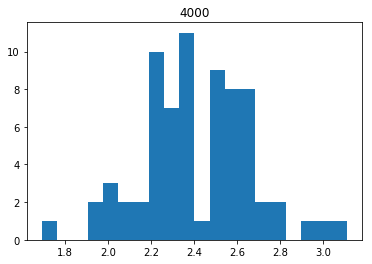

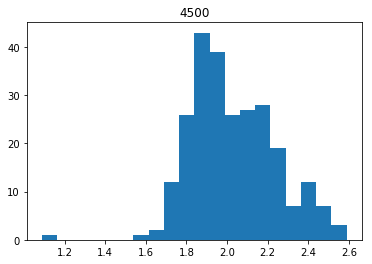

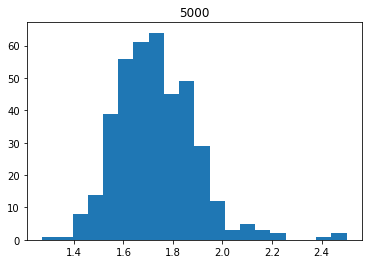

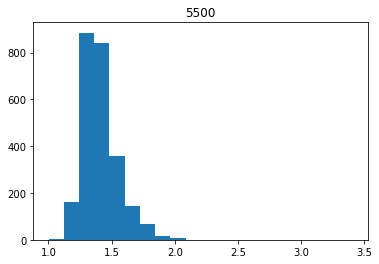

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


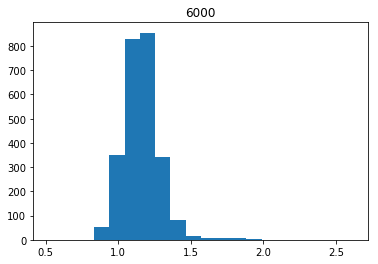

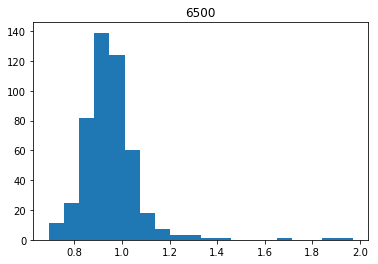

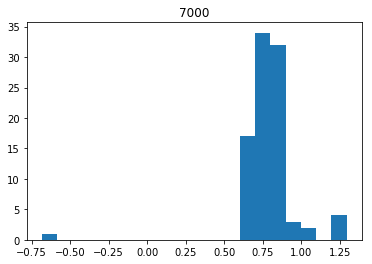

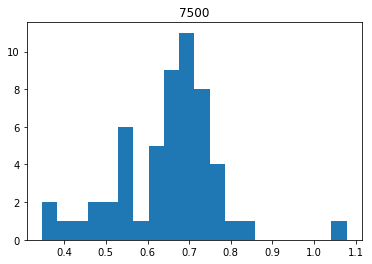

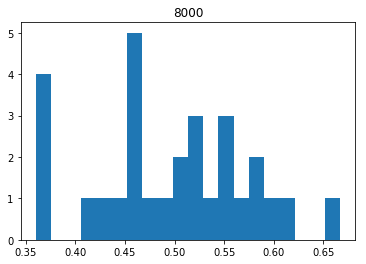

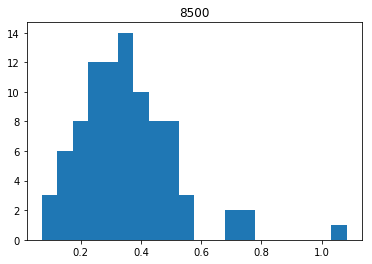

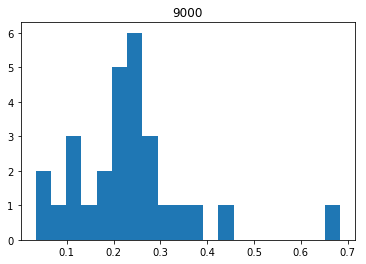

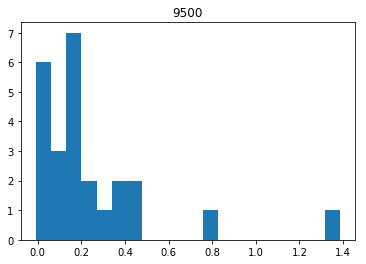

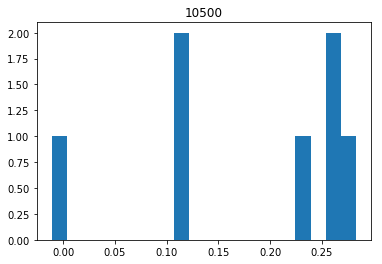

In [23]:
#create histogram for each temperature class for 100 pc
for i in temps2:
    same_temp = np.array([])
    for j in range(len(G_K_100)):
        if (G_K_100[j,2] == i):
            same_temp = np.append(same_temp,G_K_100[j,0])
    plt.figure()
    plt.hist(same_temp,range = [min(same_temp),max(same_temp)],bins=20)
    plt.title(str(i))
    plt.show()

        

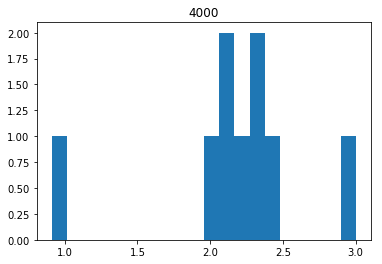

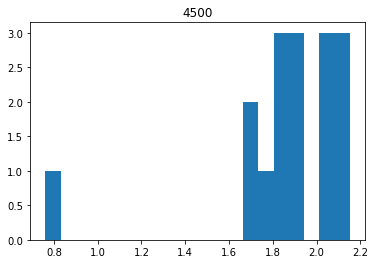

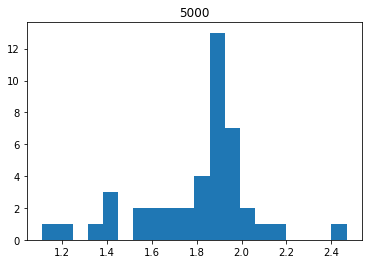

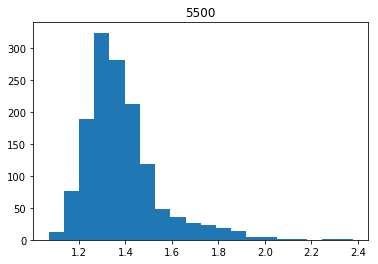

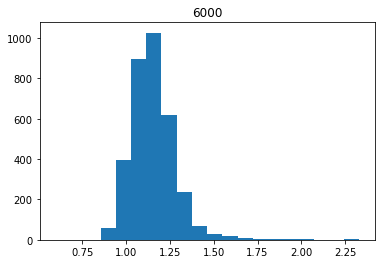

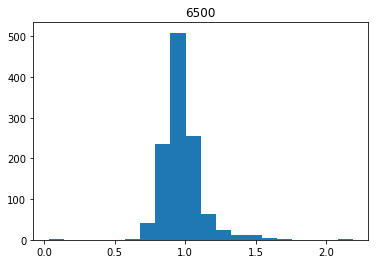

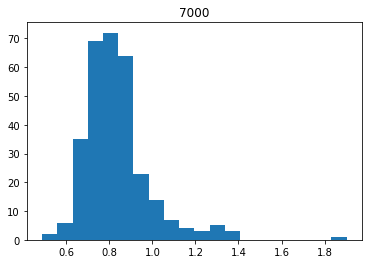

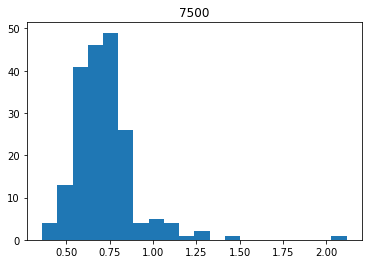

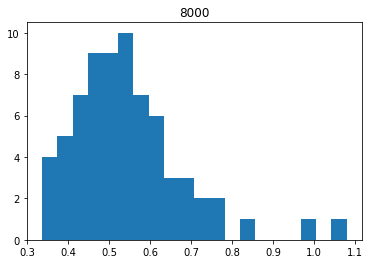

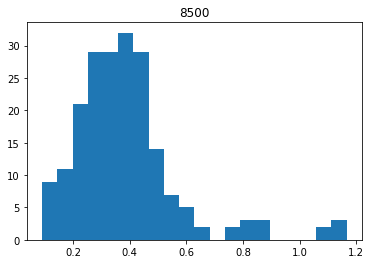

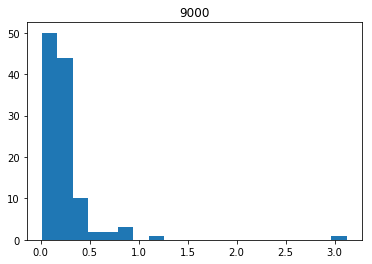

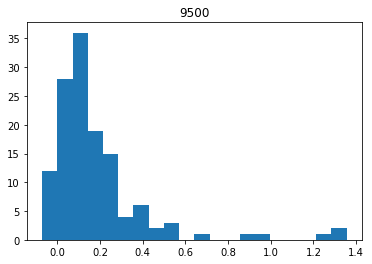

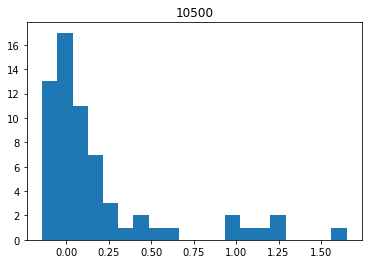

In [24]:
for i in temps2:
    same_temp = np.array([])
    for j in range(len(G_K_150)):
        if (G_K_150[j,2] == i):
            same_temp = np.append(same_temp,G_K_150[j,0])
    plt.figure()
    plt.hist(same_temp,range = [min(same_temp),max(same_temp)], bins = 20)
    plt.title(str(i))
    plt.show()

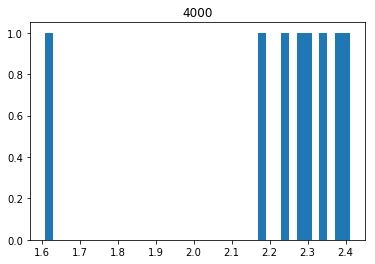

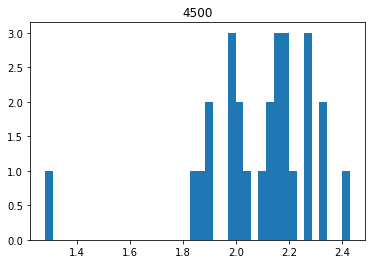

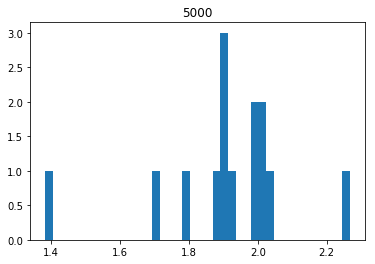

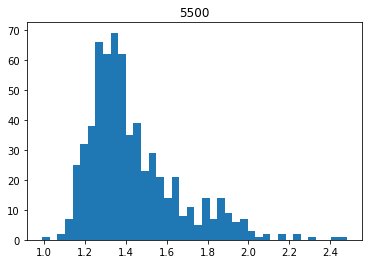

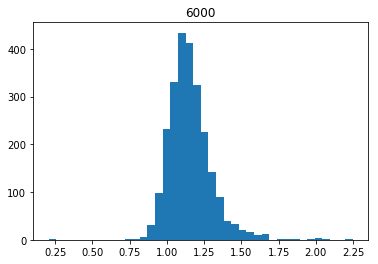

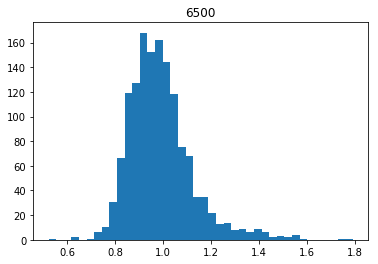

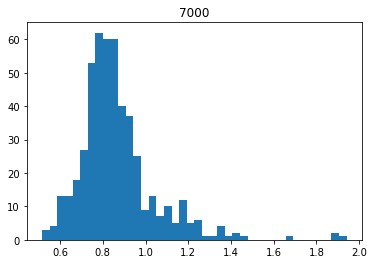

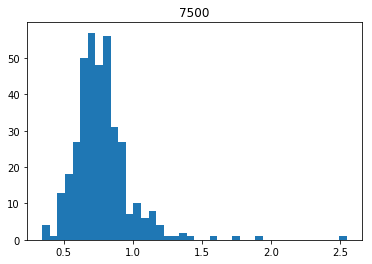

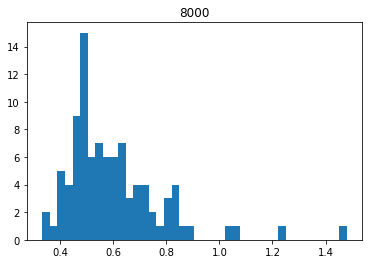

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


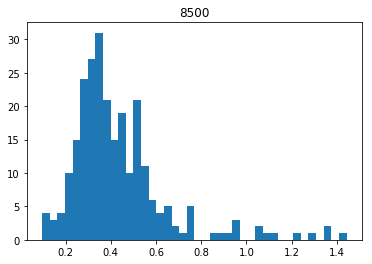

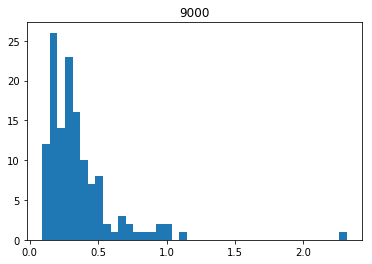

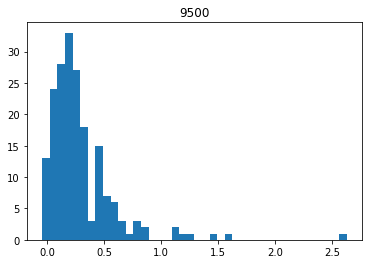

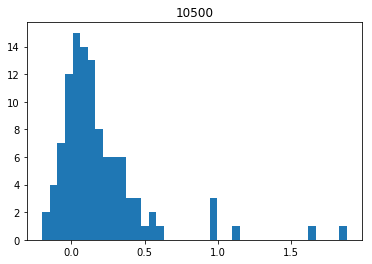

In [25]:
for i in temps2:
    same_temp = np.array([])
    for j in range(len(G_K_200)):
        if (G_K_200[j,2] == i):
            same_temp = np.append(same_temp,G_K_200[j,0])
    plt.figure()
    plt.hist(same_temp,range = [min(same_temp),max(same_temp)],bins = 40)
    plt.title(str(i))
    plt.show()

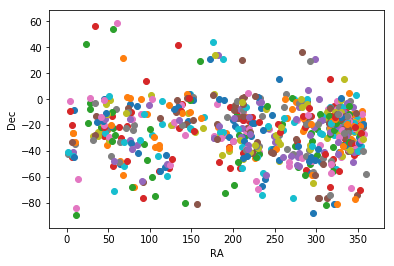

640


In [26]:
#Plot Coordinates of all stars at 5000 K and 200 pc 
number = 0
plt.figure()
for i in range(len(G_K_200)):
    if (G_K_200[i,2] == 5500):
        number = number +1
        plt.scatter(G_K_200[i,3],G_K_200[i,4])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()
print(number)

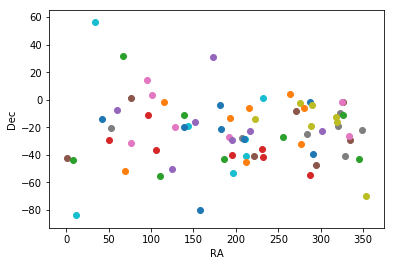

73


In [27]:
#plot coordinates of stars in secondary peak for 5500 K stars at 200 pc
number = 0
plt.figure()
for i in range(len(G_K_200)):
    if (G_K_200[i,2] == 5500 and G_K_200[i,0] >= 1.7 and G_K_200[i,0] <= 2.0):
        number = number +1
        plt.scatter(G_K_200[i,3],G_K_200[i,4])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()
print(number)

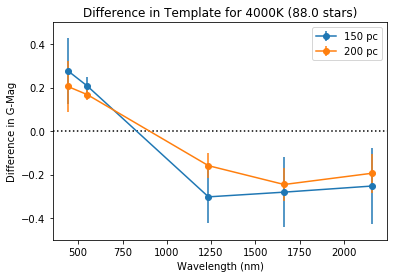

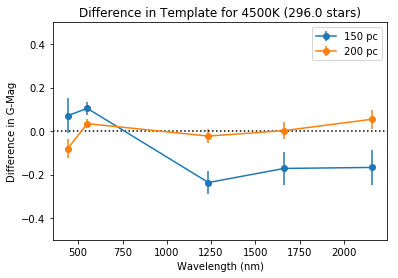

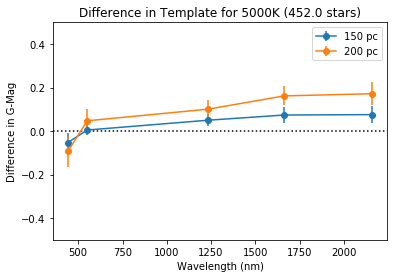

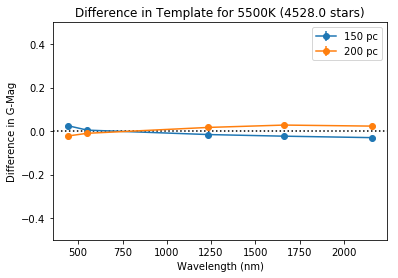

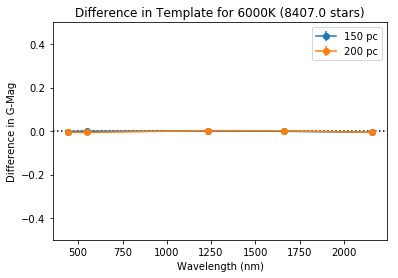

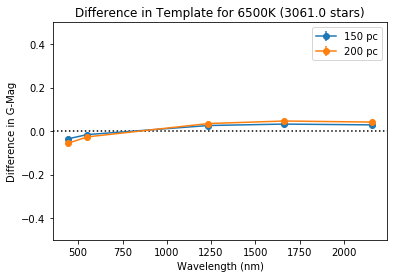

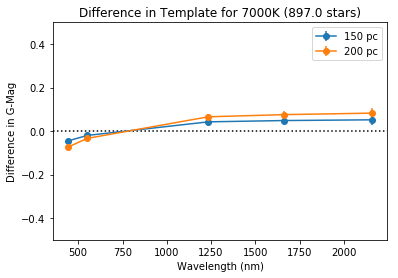

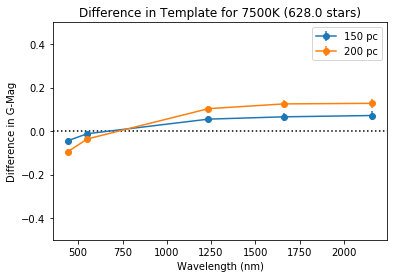

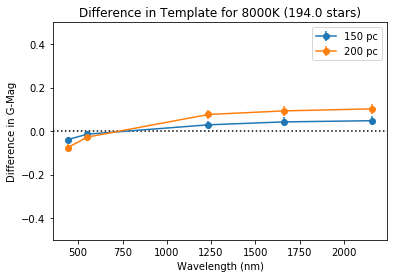

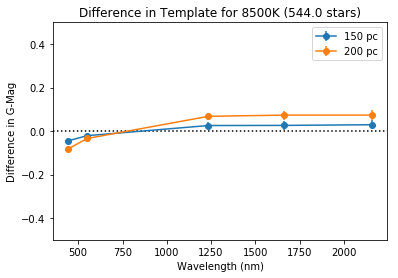

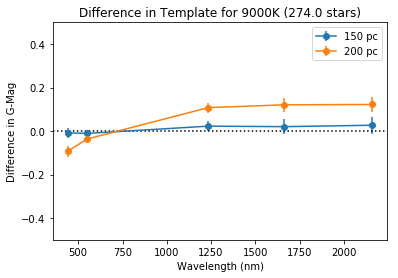

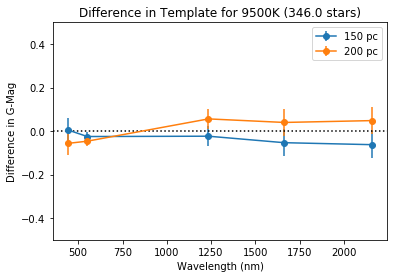

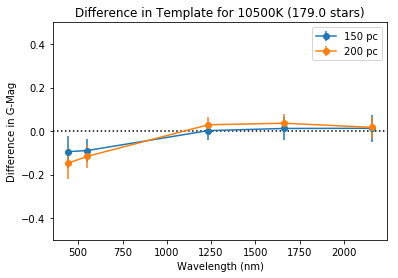

In [28]:
#Calculate average G-Mag for all temperatures 
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('Template_Differences.pdf')

diff150 = np.zeros([len(temps2),len(wvl2)])
diff200 = np.zeros([len(temps2),len(wvl2)])
diff_std150 = np.zeros([len(temps2),len(wvl2)])
diff_std200 = np.zeros([len(temps2),len(wvl2)])
for i in range(0,len(temps2)): 
    for j in range(len(wvl2)):
        diff150[i,j] = temp_mags150[i,j] - temp_mags100[i,j]
        diff200[i,j] = temp_mags200[i,j] - temp_mags100[i,j]
        diff_std150[i,j] = math.sqrt(math.pow(temp_std150[i,j],2) + math.pow(temp_std100[i,j],2))
        diff_std200[i,j] = math.sqrt(math.pow(temp_std200[i,j],2) + math.pow(temp_std100[i,j],2))
    num_star = num_stars[i+1]
    plt.figure()
    plt.errorbar(wvl2, diff150[i,:],yerr = diff_std150[i,:],linestyle = '-', marker = 'o',label = '150 pc')
    plt.errorbar(wvl2, diff200[i,:],yerr = diff_std200[i,:],linestyle = '-', marker = 'o',label = '200 pc')
    plt.axhline(linestyle = ':', color = 'k')
    plt.ylim(ymin=-0.5,ymax=0.5)
    plt.title('Difference in Template for '+ str(temps2[i]) + 'K (' + str(num_star) + ' stars)' )
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Difference in G-Mag')
    plt.legend()
    pp.savefig()
pp.close()


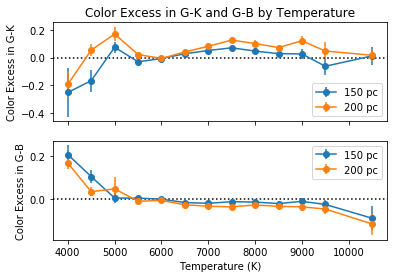

In [57]:
#Plot G-B over each G-K bin for 100 pc, 150 pc and 200 pc

pp = PdfPages('Distance_SEDs_colorexcess.pdf')
#Plot of G-K
f, axarr = plt.subplots(2, sharex=True)
axarr[0].errorbar(temps2, diff150[:,4],yerr = diff_std150[:,4],linestyle = '-', marker = 'o',label = '150 pc')
axarr[0].errorbar(temps2, diff200[:,4],yerr = diff_std200[:,4],linestyle = '-', marker = 'o',label = '200 pc')
axarr[0].axhline(linestyle = ':', color = 'k')
axarr[0].set_title('Color Excess in G-K and G-B by Temperature' )
axarr[0].set_ylabel('Color Excess in G-K')
axarr[0].legend()

#Plot of G-B
axarr[1].errorbar(temps2, diff150[:,1],yerr = diff_std150[:,1],linestyle = '-', marker = 'o',label = '150 pc')
axarr[1].errorbar(temps2, diff200[:,1],yerr = diff_std200[:,1],linestyle = '-', marker = 'o',label = '200 pc')
axarr[1].axhline(linestyle = ':', color = 'k')
axarr[1].set_xlabel('Temperature (K)')
axarr[1].set_ylabel('Color Excess in G-B')
axarr[1].legend()
pp.savefig()

pp.close()

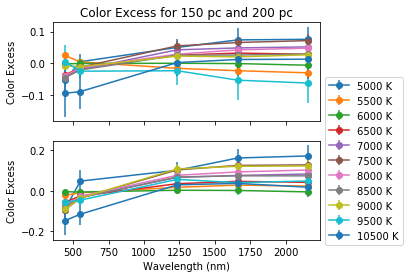

In [63]:
#Plot relative SED by distance 

pp = PdfPages('Distance_SEDs_colorexcess2.pdf')
f, axarr = plt.subplots(2, sharex=True)

for i in range(2,len(temps2)): 
    axarr[0].errorbar(wvl2,diff150[i,:],yerr = diff_std150[i,:],linestyle = '-', marker = 'o',label = str(temps2[i]) + ' K')
axarr[0].set_title('Color Excess for 150 pc and 200 pc')
axarr[0].set_ylabel('Color Excess')
box = axarr[0].get_position()
axarr[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
axarr[0].legend(loc='upper left', bbox_to_anchor=(1, 0.5))

for i in range(2,len(temps2)): 
    axarr[1].errorbar(wvl2,diff200[i,:],yerr = diff_std200[i,:],linestyle = '-', marker = 'o',label = str(temps2[i]) + ' K')
axarr[1].set_xlabel('Wavelength (nm)')
axarr[1].set_ylabel('Color Excess')
box = axarr[1].get_position()
axarr[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

pp.savefig()
pp.close()


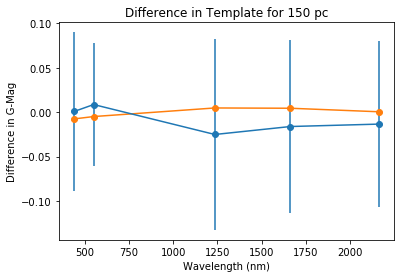

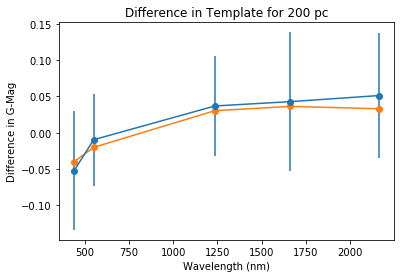

In [61]:
mean_diff150 = np.zeros(len(wvl2))
mean_diff_err150 = np.zeros(len(wvl2))
weight_mean150 = np.zeros(len(wvl2))
for i in range(len(wvl2)):
    mean_diff150[i] = np.mean(diff150[:,i])
    mean_diff_err150[i] = np.std(diff150[:,i])
    weightsum = 0;
    weights = 0
    for j in range (len(temps2)):
        weightsum = weightsum+stars150[j]*diff150[j,i]
        weights = weights + stars150[j]
    weight_mean150[i] = weightsum/weights    
plt.figure()
plt.errorbar(wvl2, mean_diff150, yerr = mean_diff_err150, linestyle = '-', marker = 'o')
plt.plot(wvl2,weight_mean150,linestyle = '-', marker = 'o')
plt.title('Difference in Template for 150 pc')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Difference in G-Mag')

mean_diff200 = np.zeros(len(wvl2))
mean_diff_err200 = np.zeros(len(wvl2))
weight_mean200 = np.zeros(len(wvl2))
for i in range(len(wvl2)):
    mean_diff200[i] = np.mean(diff200[:,i])
    mean_diff_err200[i] = np.std(diff200[:,i])
    weightsum = 0;
    weights = 0
    for j in range (len(temps2)):
        weightsum = weightsum+stars200[j]*diff200[j,i]
        weights = weights + stars200[j]
    weight_mean200[i] = weightsum/weights    
plt.figure()
plt.errorbar(wvl2, mean_diff200, yerr = mean_diff_err200, linestyle = '-', marker = 'o')
plt.plot(wvl2,weight_mean200,linestyle = '-', marker = 'o')
plt.title('Difference in Template for 200 pc')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Difference in G-Mag')
plt.show()

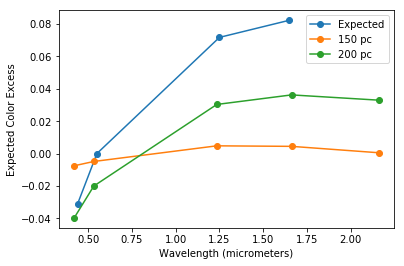

In [31]:
#Extinction 
wvl4 = [420/1000, 532/1000, 1235/1000, 1662/1000, 2159/1000]
wvl3 = np.array([1.65, 1.25, 0.55, 0.44])
Av = np.array([0.176, 0.282, 1.00, 1.31])
Color_Ex = (np.ones(len(Av)) - Av)/10

plt.figure()
plt.plot(wvl3,Color_Ex,linestyle = '-', marker = 'o',label = 'Expected')
plt.xlabel('Wavelength (micrometers)')
plt.ylabel('Expected Color Excess')
plt.plot(wvl4,weight_mean150,linestyle = '-', marker = 'o',label = '150 pc')
plt.plot(wvl4,weight_mean200,linestyle = '-', marker = 'o', label  = '200 pc')
plt.legend()
plt.show()


[[  2.77482236e-01   2.07330310e-01  -3.02505370e-01  -2.80851417e-01
   -2.52718302e-01]
 [  7.11007006e-02   1.04511104e-01  -2.36652398e-01  -1.71835402e-01
   -1.67159565e-01]
 [ -5.29025137e-02   4.85132407e-03   5.00895796e-02   7.38292338e-02
    7.57486587e-02]
 [  2.48920509e-02   4.32882574e-03  -1.60156024e-02  -2.34740554e-02
   -3.01911424e-02]
 [ -2.10510601e-03  -5.68922780e-04   2.95928362e-06  -9.72346101e-04
   -6.16287543e-03]
 [ -3.59215142e-02  -1.61211793e-02   2.55787441e-02   3.21918574e-02
    2.84837602e-02]
 [ -4.54964344e-02  -1.99453198e-02   4.25024871e-02   4.84266941e-02
    5.18421825e-02]
 [ -4.42862579e-02  -1.21673711e-02   5.49240168e-02   6.56195190e-02
    7.16035877e-02]
 [ -3.92191528e-02  -1.41487934e-02   2.88044533e-02   4.22926729e-02
    4.76960318e-02]
 [ -4.50576463e-02  -2.10543285e-02   2.55620294e-02   2.61140965e-02
    2.92362684e-02]
 [ -8.16464334e-03  -1.06823655e-02   2.27174783e-02   2.02894909e-02
    2.68417050e-02]
 [  5.2530

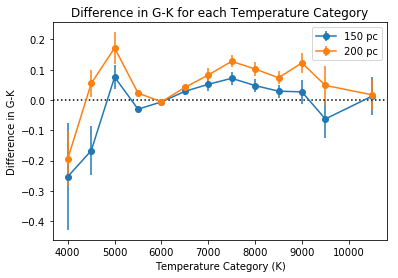

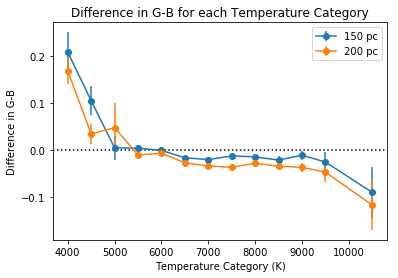

In [32]:
#Plot G-K and G-B over each temperature bin for 100 pc, 150 pc and 200 pc

temps3 = [4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500]
print(diff150)

pp2 = PdfPages('Temperature_Differences.pdf')
#Plot of G-K
plt.errorbar(temps2, diff150[:,4],yerr = diff_std150[:,4],linestyle = '-', marker = 'o',label = '150 pc')
plt.errorbar(temps2, diff200[:,4],yerr = diff_std200[:,4],linestyle = '-', marker = 'o',label = '200 pc')
plt.axhline(linestyle = ':', color = 'k')
plt.title('Difference in G-K for each Temperature Category' )
plt.xlabel('Temperature Category (K)')
plt.ylabel('Difference in G-K')
plt.legend()
pp2.savefig()
plt.show()

#Plot of G-B
plt.figure()
plt.errorbar(temps2, diff150[:,1],yerr = diff_std150[:,1],linestyle = '-', marker = 'o',label = '150 pc')
plt.errorbar(temps2, diff200[:,1],yerr = diff_std200[:,1],linestyle = '-', marker = 'o',label = '200 pc')
plt.axhline(linestyle = ':', color = 'k')
plt.title('Difference in G-B for each Temperature Category' )
plt.xlabel('Temperature Category (K)')
plt.ylabel('Difference in G-B')
plt.legend()
pp2.savefig()
plt.show()

pp2.close()

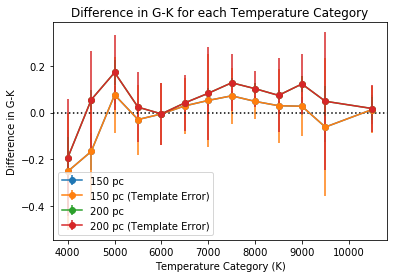

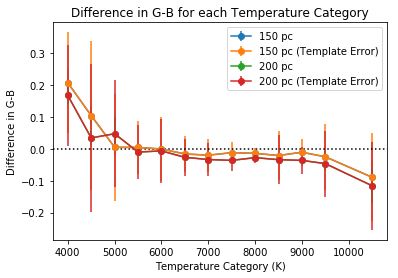

In [33]:
#Plot G-K and G-B over each temperature bin for 100 pc, 150 pc and 200 pc

pp3 = PdfPages('Temperature_Differences2.pdf')
#Plot of G-K
plt.errorbar(temps2, diff150[:,4],yerr = diff_std150[:,4],linestyle = '-', marker = 'o',label = '150 pc')
plt.errorbar(temps2, diff150[:,4],yerr = temp_std[:,4],linestyle = '-', marker = 'o',label = '150 pc (Template Error)')
plt.errorbar(temps2, diff200[:,4],yerr = diff_std200[:,4],linestyle = '-', marker = 'o',label = '200 pc')
plt.errorbar(temps2, diff200[:,4],yerr = temp_std[:,4],linestyle = '-', marker = 'o',label = '200 pc (Template Error)')
plt.axhline(linestyle = ':', color = 'k')
plt.title('Difference in G-K for each Temperature Category' )
plt.xlabel('Temperature Category (K)')
plt.ylabel('Difference in G-K')
plt.legend()
pp3.savefig()
plt.show()

#Plot of G-B
plt.figure()
plt.errorbar(temps2, diff150[:,1],yerr = diff_std150[:,1],linestyle = '-', marker = 'o',label = '150 pc')
plt.errorbar(temps2, diff150[:,1],yerr = temp_std[:,1],linestyle = '-', marker = 'o',label = '150 pc (Template Error)')
plt.errorbar(temps2, diff200[:,1],yerr = diff_std200[:,1],linestyle = '-', marker = 'o',label = '200 pc')
plt.errorbar(temps2, diff200[:,1],yerr = temp_std[:,1],linestyle = '-', marker = 'o',label = '200 pc (Template Error)')
plt.axhline(linestyle = ':', color = 'k')
plt.title('Difference in G-B for each Temperature Category' )
plt.xlabel('Temperature Category (K)')
plt.ylabel('Difference in G-B')
plt.legend()
pp3.savefig()
plt.show()

pp3.close()

In [34]:
#assign stars of 6000 K a distance category
distance_cat2 = np.zeros(len(Dist))
for i in range(len(temp_cat)):
    if (temp_cat[i] == 6000):
        for j in range(20,200,20):
            if (j == 20):
                if (Dist[i] <= j):
                    distance_cat2[i] = j
            if (Dist[i] <= j and Dist[i] > j-20):
                distance_cat2[i] = j 
print(distance_cat2)          

[   0.    0.    0. ...,  140.  180.    0.]


[[-0.78200054 -0.16859999  0.82599926  1.08299923  1.13399982]
 [-1.20199966 -0.22239751  1.16300011  1.59500027  1.66699982]
 [-0.11499977 -0.21692886  0.19099998  0.17299986  0.17999983]
 [-2.15500021 -0.2255789   1.70000029  2.29300022  2.49300051]
 [-0.72700024 -0.2233761   0.8739996   1.12699986  1.20800018]
 [-1.0369997  -0.22255915  1.03200006  1.30599976  1.37299967]
 [-1.02400017 -0.22240678  0.91499996  1.18900013  1.24600029]
 [-0.84600067 -0.22740812  0.91899967  1.15999985  1.21199989]
 [-0.92300034 -0.22890774  0.9119997   1.19299984  1.23699951]]
[[ 0.          0.06980143  0.          0.          0.        ]
 [ 0.          0.06629524  0.          0.          0.        ]
 [ 0.          0.04844865  0.          0.          0.        ]
 [ 0.          0.16822024  0.          0.          0.        ]
 [ 0.          0.04008731  0.          0.          0.        ]
 [ 0.          0.04199541  0.          0.          0.        ]
 [ 0.          0.06167994  0.          0.          0. 

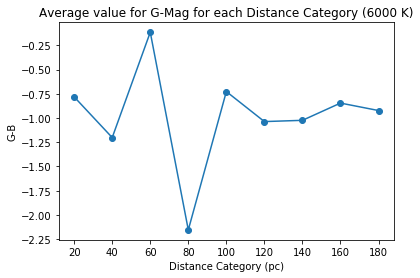

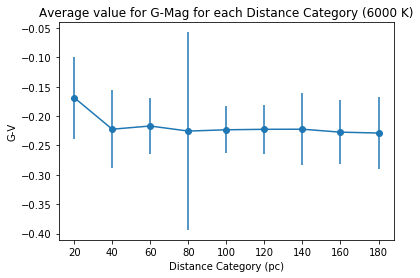

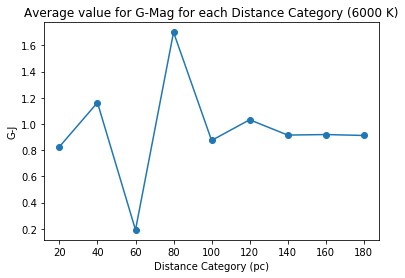

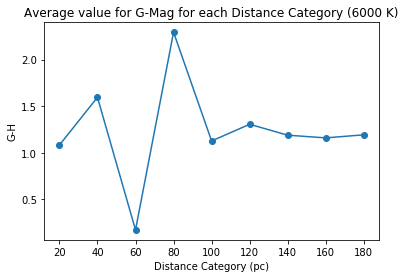

In [35]:
#Determine average value of G-Mag for each distance category 
distances = list(range(20,200,20))
for i in range(20,200,20):
    G_B_array = ma.array([])
    G_V_array = ma.array([])
    G_J_array = ma.array([])
    G_H_array = ma.array([])
    G_K_array = ma.array([])
    for j in range(len(distance_cat2)):
        if (distance_cat2[j] == i):
            G_V_array = np.append(G_V_array,Gmags[j]-Vmags[j])
            G_B_array = np.append(G_B_array,Gmags[i]-Bmags[i])
            G_J_array = np.append(G_J_array,Gmags[i]-Jmags[i])
            G_H_array = np.append(G_H_array,Gmags[i]-Hmags[i])
            G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
    array = [np.mean(G_B_array), np.mean(G_V_array), np.mean(G_J_array), np.mean(G_H_array), np.mean(G_K_array)]
    err  = [np.std(G_B_array), np.std(G_V_array), np.std(G_J_array), np.std(G_H_array), np.std(G_K_array)]
    if (i == 20):
        dist_array = array
        err_array = err
    if (i != 20):
        dist_array = np.vstack((dist_array,array))
        err_array = np.vstack((err_array,err))
print(dist_array)
print(err_array)
for i in range(0,4):
    plt.figure()
    plt.errorbar(distances, dist_array[:,i], yerr = err_array[:,i], linestyle = '-', marker = 'o')
    plt.xlabel('Distance Category (pc)')
    if i == 0: plt.ylabel('G-B')
    if i == 1: plt.ylabel('G-V')
    if i == 2: plt.ylabel('G-J')
    if i == 3: plt.ylabel('G-H')
    if i == 4: plt.ylabel('G-K')
    plt.title('Average value for G-Mag for each Distance Category (6000 K)')
   
     
        
        

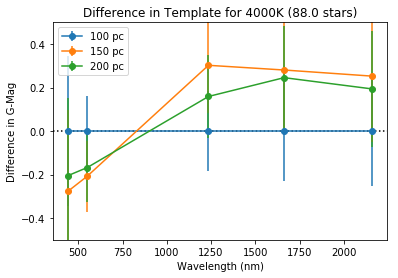

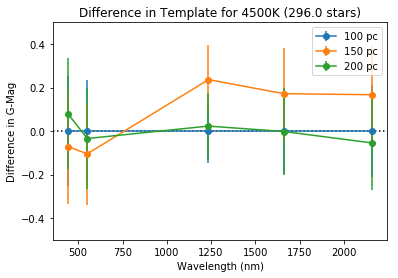

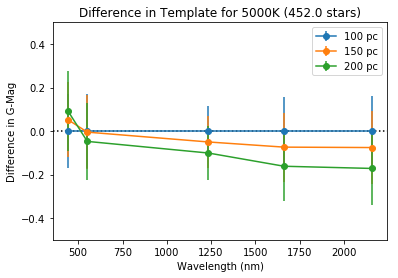

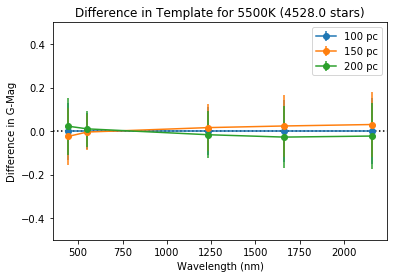

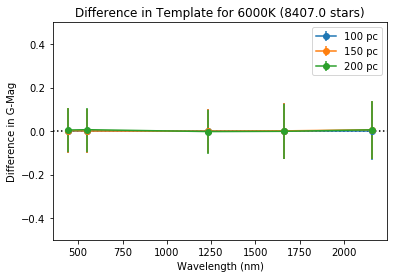

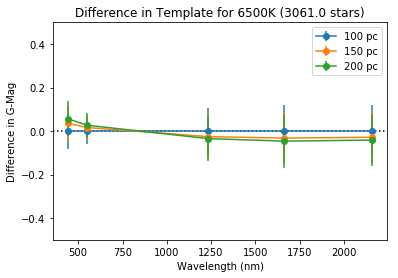

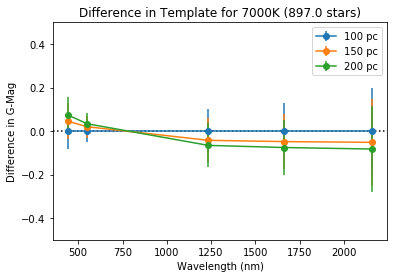

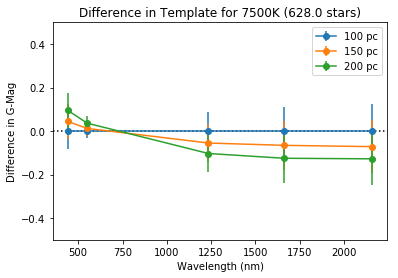

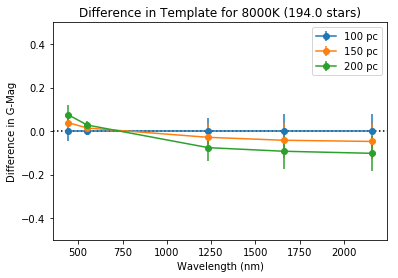

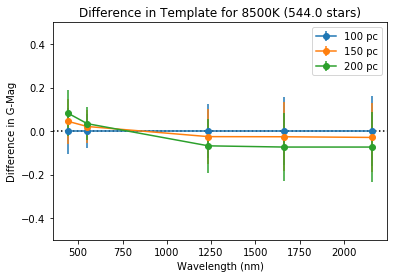

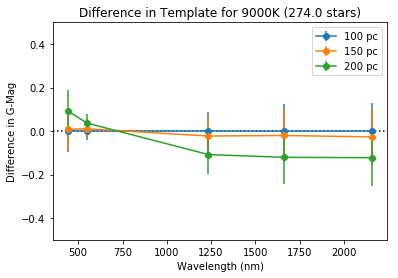

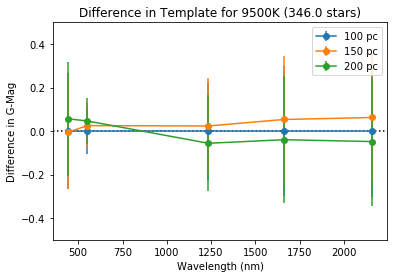

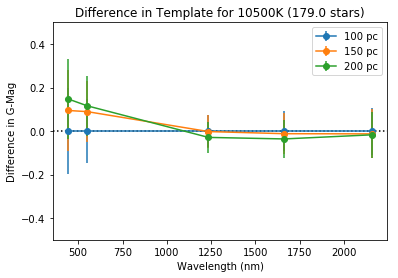

In [36]:
#Plot G-Mag of all stars minus G-Mag for distance stars
all_diff100 = np.zeros([len(temps2),len(wvl2)])
all_diff150 = np.zeros([len(temps2),len(wvl2)])
all_diff200 = np.zeros([len(temps2),len(wvl2)])
all_diff_std100 = np.zeros([len(temps2),len(wvl2)])
all_diff_std150 = np.zeros([len(temps2),len(wvl2)])
all_diff_std200 = np.zeros([len(temps2),len(wvl2)])
for i in range(0,len(temps2)): 
    for j in range(len(wvl2)):
        all_diff100[i,j] = temp_mags[i,j] - temp_mags100[i,j]
        all_diff150[i,j] = temp_mags[i,j] - temp_mags150[i,j]
        all_diff200[i,j] = temp_mags[i,j] - temp_mags200[i,j]
        all_diff_std100[i,j] = math.sqrt(math.pow(temp_std[i,j],2) + math.pow(temp_std100[i,j],2))
        all_diff_std150[i,j] = math.sqrt(math.pow(temp_std[i,j],2) + math.pow(temp_std150[i,j],2))
        all_diff_std200[i,j] = math.sqrt(math.pow(temp_std[i,j],2) + math.pow(temp_std200[i,j],2))
    num_star = num_stars[i+1]
    plt.figure()
    plt.errorbar(wvl2, all_diff100[i,:],yerr = all_diff_std100[i,:],linestyle = '-', marker = 'o',label = '100 pc')
    plt.errorbar(wvl2, all_diff150[i,:],yerr = all_diff_std150[i,:],linestyle = '-', marker = 'o',label = '150 pc')
    plt.errorbar(wvl2, all_diff200[i,:],yerr = all_diff_std200[i,:],linestyle = '-', marker = 'o',label = '200 pc')
    plt.axhline(linestyle = ':', color = 'k')
    plt.ylim(ymin=-0.5,ymax=0.5)
    plt.title('Difference in Template for '+ str(temps2[i]) + 'K (' + str(num_star) + ' stars)' )
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Difference in G-Mag')
    plt.legend()




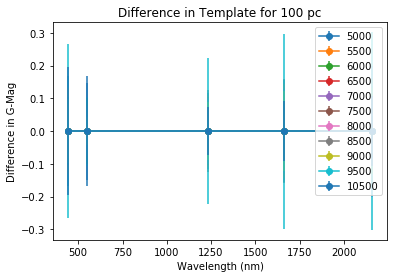

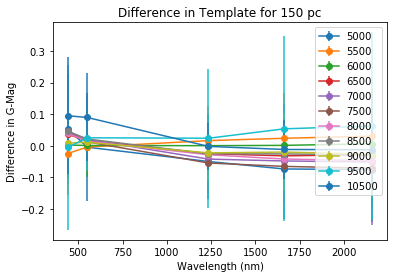

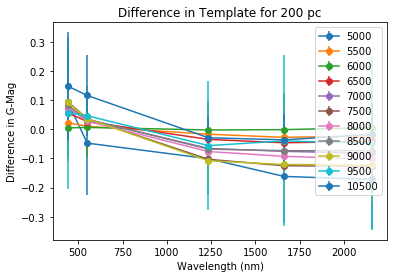

In [37]:
#Plot relative SED by distance 
plt.figure()
for i in range(2,len(temps2)): 
    plt.errorbar(wvl2,all_diff100[i,:],yerr = all_diff_std100[i,:],linestyle = '-', marker = 'o',label = str(temps2[i]))
    plt.title('Difference in Template for 100 pc')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Difference in G-Mag')
    plt.legend()

plt.figure()
for i in range(2,len(temps2)): 
    plt.errorbar(wvl2,all_diff150[i,:],yerr = all_diff_std150[i,:],linestyle = '-', marker = 'o',label = str(temps2[i]))
    plt.title('Difference in Template for 150 pc')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Difference in G-Mag')
    plt.legend()

plt.figure()
for i in range(2,len(temps2)): 
    plt.errorbar(wvl2,all_diff200[i,:],yerr = all_diff_std200[i,:],linestyle = '-', marker = 'o',label = str(temps2[i]))
    plt.title('Difference in Template for 200 pc')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Difference in G-Mag')
    plt.legend()